<h1>Telco Customer Churn - Predictive Modeling


In [82]:
#Importing Dependencies
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTEENN
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

<h2>Loading Data

In [83]:
#Load Cleaned Data
df = pd.read_csv('cleaned_churn_data.csv')

<h2>Data Preparation

In [84]:
X = df.drop('Churn', axis=1)
y = df['Churn']

In [85]:
# Convert categorical variables
X = pd.get_dummies(X).astype(int)

In [86]:
#Splitting Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

<h2>Random Forest Model

In [87]:
model_rf = RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    random_state=100,
    max_depth=6,
    min_samples_leaf=8
)

In [88]:
model_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, min_samples_leaf=8, random_state=100)

In [89]:
# Predict and evaluate on the test set
y_pred = model_rf.predict(X_test)

baseline_score = model_rf.score(X_test, y_test)
print("Baseline Model Score:", baseline_score)
print("\nClassification Report (Baseline):")
print(classification_report(y_test, y_pred, labels=[0, 1]))

Baseline Model Score: 0.7946048272598202

Classification Report (Baseline):
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1552
           1       0.66      0.47      0.55       561

    accuracy                           0.79      2113
   macro avg       0.74      0.69      0.71      2113
weighted avg       0.78      0.79      0.78      2113



<h2>Imporving Random Forest with SMOTEENN

In [90]:
# Apply SMOTEENN on the entire dataset
sm = SMOTEENN(random_state=100)
X_resampled, y_resampled = sm.fit_resample(X, y)

c:\Users\reddy\OneDrive\Desktop\HELLO\22 ML Projects\tf_gpu\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\reddy\OneDrive\Desktop\HELLO\22 ML Projects\tf_gpu\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\reddy\OneDrive\Desktop\HELLO\22 ML Projects\tf_gpu\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer

In [91]:
print("Resampled class distribution:", np.bincount(y_resampled))

Resampled class distribution: [2659 3225]


In [92]:
# Split resampled data
xr_train, xr_test, yr_train, yr_test = train_test_split(
    X_resampled, y_resampled,
    test_size=0.2,
    random_state=100
)

In [93]:
# Train a new RandomForest model on the resampled data
model_rf_smote = RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    random_state=100,
    max_depth=6,
    min_samples_leaf=8
)

model_rf_smote.fit(xr_train, yr_train)

RandomForestClassifier(max_depth=6, min_samples_leaf=8, random_state=100)

In [94]:
# Predict and evaluate on the SMOTEENN test set
yr_pred = model_rf_smote.predict(xr_test)
smote_score = model_rf_smote.score(xr_test, yr_test)
print("\nSMOTEENN Model Score:", smote_score)
print("\nClassification Report (SMOTEENN):")
print(classification_report(yr_test, yr_pred, labels=[0, 1]))


SMOTEENN Model Score: 0.9345794392523364

Classification Report (SMOTEENN):
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       559
           1       0.93      0.95      0.94       618

    accuracy                           0.93      1177
   macro avg       0.94      0.93      0.93      1177
weighted avg       0.93      0.93      0.93      1177



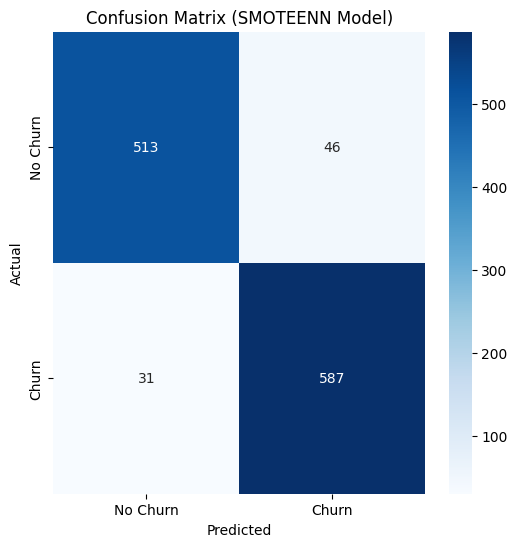

In [95]:
# Confusion Matrix for the SMOTEENN model
cm = confusion_matrix(yr_test, yr_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Churn', 'Churn'], 
            yticklabels=['No Churn', 'Churn'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix (SMOTEENN Model)')
plt.show()

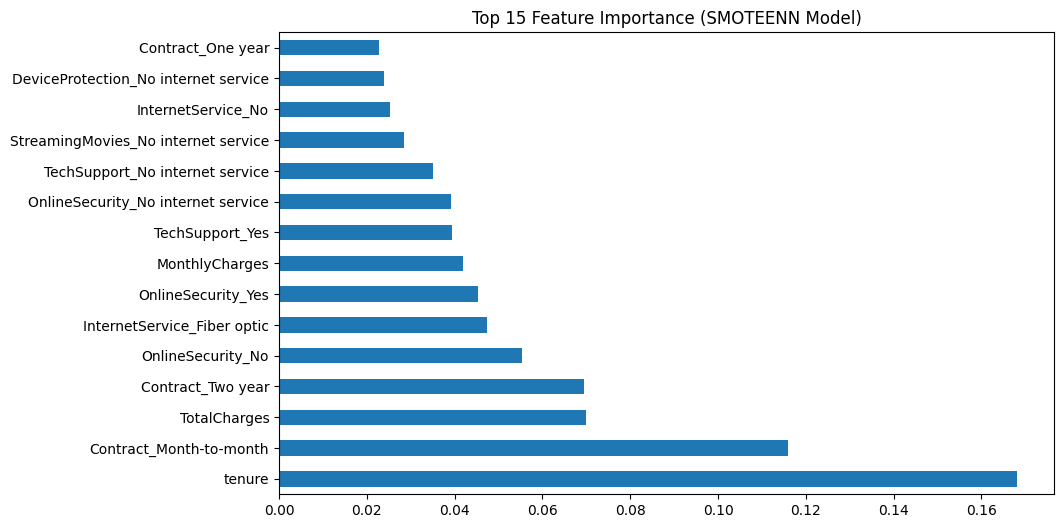

In [96]:
# Feature Importance (from SMOTEENN Model)
feature_importance = pd.Series(model_rf_smote.feature_importances_, index=X.columns)
plt.figure(figsize=(10, 6))
feature_importance.nlargest(15).plot(kind='barh')
plt.title('Top 15 Feature Importance (SMOTEENN Model)')
plt.show()

<h2>Save Artifacts

In [97]:
joblib.dump(model_rf_smote, 'churn_model.pkl')
X.columns.to_series().to_csv('model_features.csv', index=False)